# Console Analyses

Algumas estatísticas e analises com os dados encontrados.

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

sales_df = pd.read_csv('../data/console_weekly_sales.csv')
consoles_df = pd.read_csv('../data/console_stats.csv')

sales_df['week'] = pd.to_datetime(sales_df['week'])

merged_df = sales_df.merge(consoles_df, on='console')

## Análise Exploratória Inicial
### Estatísticas Descritivas
Veremos o mercado de consoles trabalha com uma margem muito baixa entre preço e custo, e como isso varia conforme o custo e tipo do console. Além disso, é pssível observar que há uma grande volatilidade no numero de vendas semanais, podendo concluir em ciclos de vendas com picos e quedas muito altas.


#### Métricas por console
- Vendas médias semanais
- Vendas totais acumuladas (soma de todas as semanas)
- Desvio padrão das vendas (para medir volatibilidade)
- Margem bruta

In [77]:
# Calcular estatísticas básicas
console_metrics = sales_df.groupby('console')['sales'].agg(
    avg_weekly_sales=('mean'),
    total_sales=('sum'),
    sales_std=('std')
).reset_index()

# Adicionar dados de preço e custo
console_metrics = consoles_df[['console','type', '2025 price', '2025 cost']].merge(console_metrics, on='console')

# Calcular margem bruta
console_metrics['gross_margin'] = ((console_metrics['2025 price'] - console_metrics['2025 cost']) 
                                  / console_metrics['2025 price'])

# Formatando os resultados
console_metrics = console_metrics.round({
    'avg_weekly_sales': 2,
    'total_sales': 0,
    'sales_std': 2,
    'gross_margin': 3
}).rename(columns={
    '2025 price': 'preco_lancamento_ajustado',
    '2025 cost': 'custo_ajustado',
    'avg_weekly_sales': 'vendas_media_semanal',
    'total_sales': 'vendas_totais',
    'sales_std': 'volatilidade_vendas',
    'gross_margin': 'margem_bruta'
})

print("Métricas por Console:")
display(console_metrics)

Métricas por Console:


,console,type,preco_lancamento_ajustado,custo_ajustado,vendas_media_semanal,vendas_totais,volatilidade_vendas,margem_bruta
0,DS,portable,253.93,169.30,324253.00,154020176,330254.08,0.333
1,PSP,portable,409.35,311.12,130989.85,82523607,133501.14,0.240
2,Wii,static,396.56,250.64,213510.02,101630770,274957.99,0.368
3,X360,static,489.61,556.74,135653.78,85733192,177178.37,-0.137
4,PS3,static,791.57,1276.98,150172.46,87400374,161609.19,-0.613
5,3DS,portable,355.41,142.17,133934.31,75940755,172940.04,0.600
6,WiiU,static,416.47,250.72,50787.19,13560180,77356.12,0.398
7,PS4,static,547.74,523.03,201374.69,117200071,234239.43,0.045
8,XOne,static,685.02,646.58,121760.33,57957918,171904.59,0.056
9,PSV,portable,346.83,222.86,31272.12,13134292,38100.04,0.357


#### Métricas por Geração

- Vendas totais de console por geração
- Tempo entre gerações por empresa

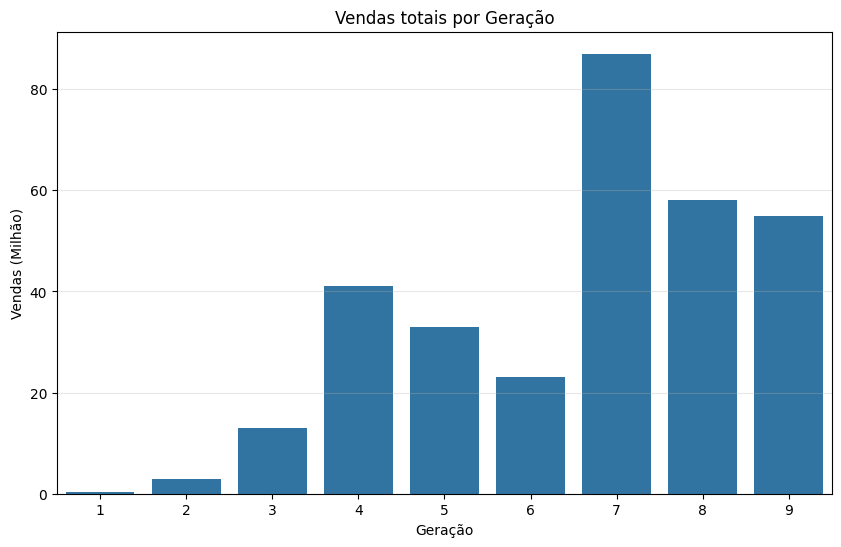

In [ ]:
gens_df = pd.read_csv('../data/companys.csv')

# Calculando média de unidades vendidas
units_by_gen = gens_df.groupby('Generation')['Units sold (million)'].median()

# Gráfico de vendas por geração
plt.figure(figsize=(10, 6))
sns.barplot(data=units_by_gen)
plt.title('Vendas totais por Geração')
plt.ylabel('Vendas (Milhão)')
plt.xlabel('Geração')
plt.grid(axis='y', alpha=0.3)
plt.show()

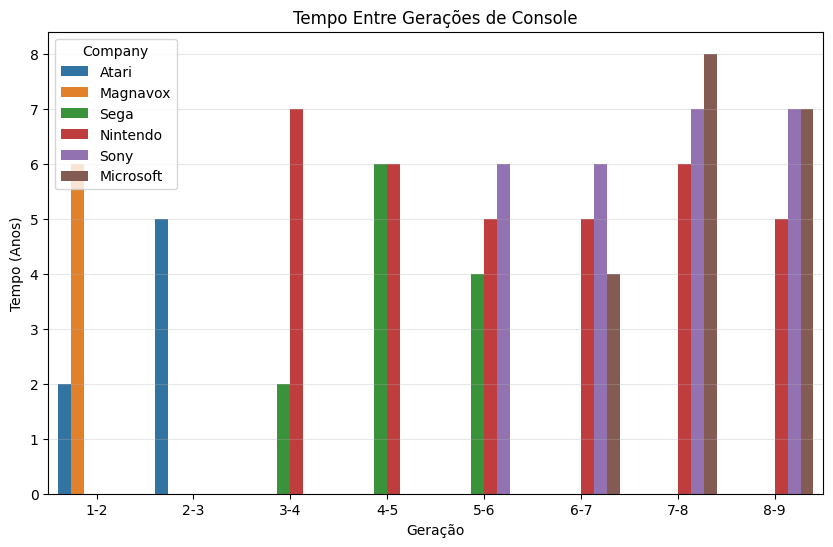

In [ ]:
# Adicionar coluna que guarda diferenças entre anos de lançamento
console_differences = gens_df.groupby('Company')['Released Year'].diff()
gens_df['Time Since Last Release'] = console_differences

# Ordenando por geração
consoles_by_gen = gens_df.dropna().sort_values(['Generation']).astype({'Time Since Last Release': int, 'Generation': str})

# Renomeando a coluna Generations pra representar os intervalos entre gerações
consoles_by_gen['Generation'] = consoles_by_gen['Generation'].apply(lambda x: str(int(x) - 1) + "-" + x)

# Gráfico de tempo entre gerações
plt.figure(figsize=(10, 6))
sns.barplot(data=consoles_by_gen, x='Generation', y='Time Since Last Release', hue='Company')
plt.title('Tempo Entre Gerações de Console')
plt.ylabel('Tempo (Anos)')
plt.xlabel('Geração')
plt.grid(axis='y', alpha=0.3)
plt.show()

#### Análise de sobrevivência dos consoles 
Considerando um mínimo semanal de vendas, analizamos quanto tempo demorou para que as vendas semanais de cada console caíssem abaixo desse mínimo.

Linhas em laranja representam consoles com um número de vendas que já chegou ao mínimo. Linhas em ciano representam consoles cuja informação acaba antes de uma queda abaixo do limite ser registrada.

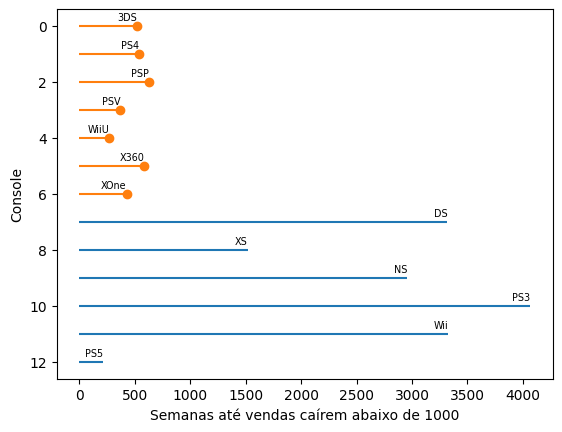

In [ ]:
min_sales = 1000

# Modela quando as vendas caem abaixo do mínimo
sales_df['sales dropped'] = (sales_df['sales'] < min_sales).astype(int)
sales_df['time until drop'] = sales_df.groupby('console')['week'].rank(method='first')

# Pra cada console, encontra a semana na qual as vendas caíram abaixo do mínimo
failed = (sales_df[(sales_df['sales dropped'] == 1) & (sales_df['sales'] > 0)]
                 .groupby('console')
                 .first()
                 .reset_index()[['console', 'time until drop']])

# Junta os consoles cujas vendas nunca caíram abaixo do mínimo
never_failed = list(set(sales_df['console']) - set(failed['console']))
never_failed_df = pd.DataFrame({
    'console': never_failed,
    'time until drop': ((sales_df.groupby('console')['week'].max() - sales_df.groupby('console')['week'].min()).dt.days)[never_failed].values
})

# Combina ambos datasets
survival_data = pd.concat([failed, never_failed_df]).reset_index()
survival_data['event occurred'] = survival_data['console'].isin(sales_df[sales_df['sales dropped'] == 1]['console']).astype(int)

# Função de gráfico de tempo de vida
def plot_lifelines(obs):
    for y, row in obs.iterrows():
        end = row['time until drop']
        
        if row['console'] in never_failed:
            # Ainda não caiu abaixo de 1000 
            plt.hlines(y, 0, end, color='C0')
            plt.text(end, y - 0.3, row['console'], ha='right', va='center', size='x-small')
        else:
            # Caiu abaixo de 1000
            plt.hlines(y, 0, end, color='C1')
            plt.text(end, y - 0.3, row['console'], ha='right', va='center', size='x-small')
            plt.plot(end, y, marker='o', color='C1')
            
    plt.xlabel('Semanas até vendas caírem abaixo de 1000')
    plt.ylabel('Console')
    plt.gca().invert_yaxis()

# Gráfico de tempo de vida
plot_lifelines(survival_data)
plt.show()

Então, usamos o método de estimativa Kaplan-Meier para calcular a probabilidade de sobrevivência de um console; ou seja, a probabilidade das vendas continuarem acima do mínimo.

In [ ]:
# Junta os tempos de vida únicos t
ts = survival_data['time until drop'].unique()
ts.sort()

at_risk = pd.Series(0, index=ts)

# Vê quantos estão em risco em cada t
for t in ts:
    k = (t <= survival_data['time until drop'])
    at_risk[t] = k.sum()

dropped = pd.Series(0, index=ts)

# Vê quantos consoles têm vendas caírem abaixo do mínimo em cada t
for t in ts:
    k = (survival_data['event occurred'] == 1) & (t == survival_data['time until drop'])
    dropped[t] = k.sum()

# Fazendo dataframe de tempos de vida
tempovida_d = dict(dropped=dropped, 
         at_risk=at_risk)
tempovida_df = pd.DataFrame(tempovida_d, index=ts)

# Calculando risco
tempovida_df['hazard'] = tempovida_df['dropped'] / tempovida_df['at_risk']

# Probabilidade de sobrevivência (probabilidade de evento não ocorrer em todo t até o t atual)
tempovida_df['surv'] = (1 - tempovida_df['hazard']).cumprod()

display(tempovida_df)

,dropped,at_risk,hazard,surv
210.0,1,13,0.076923,0.923077
267.0,1,12,0.083333,0.846154
370.0,1,11,0.090909,0.769231
425.0,1,10,0.100000,0.692308
518.0,1,9,0.111111,0.615385
541.0,1,8,0.125000,0.538462
585.0,1,7,0.142857,0.461538
629.0,1,6,0.166667,0.384615
1519.0,1,5,0.200000,0.307692
2954.0,0,4,0.000000,0.307692


O gráfico da função de sobrevivência em função do tempo é:

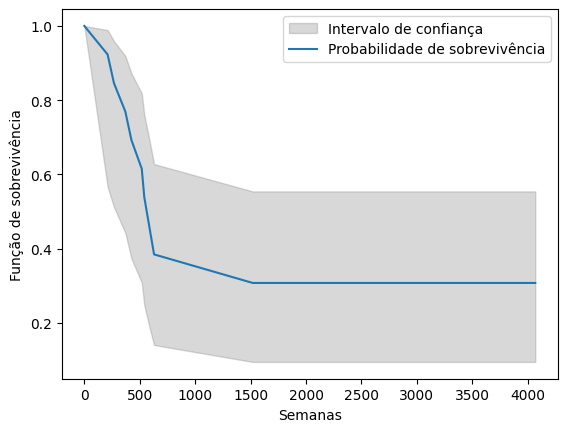

In [ ]:
kmf = KaplanMeierFitter()

# Fazendo o intervalo de confiança da estimação Kaplan-Meier
kmf.fit(survival_data['time until drop'], survival_data['event occurred'])
ci = kmf.confidence_interval_survival_function_

low, high = np.transpose(ci.values)

# Gráfico da sobrevivência
plt.fill_between(ci.index, low, high, color='gray', alpha=0.3)
kmf.survival_function_.plot(ax=plt.gca())
plt.legend(['Intervalo de confiança', 'Probabilidade de sobrevivência'])
plt.ylabel('Função de sobrevivência')
plt.xlabel('Semanas')

plt.show()

#### Métricas do mercado
- Vendas médias semanais
- Vendas totais acumuladas (soma de todas as semanas)
- Desvio padrão das vendas (para medir volatibilidade)
- Margem bruta

In [78]:
# Calcular métricas agregadas
total_revenue = (console_metrics['preco_lancamento_ajustado'] * console_metrics['vendas_totais']).sum()
total_cost = (console_metrics['custo_ajustado'] * console_metrics['vendas_totais']).sum()

market_metrics = {
    'vendas_media_semanal_mercado': sales_df['sales'].mean(),
    'vendas_totais_mercado': console_metrics['vendas_totais'].sum(),
    'volatilidade_mercado': sales_df.groupby('week')['sales'].sum().std(),
    'margem_bruta_mercado': (total_revenue - total_cost) / total_revenue
}

# Formatando para DataFrame
with pd.option_context('display.float_format', '{:.2f}'.format):
    market_metrics = pd.DataFrame(
        list(market_metrics.items()), 
        columns=['metric', 'value']
    )
    # Ajustar decimais específicos
    market_metrics['value'] = market_metrics.apply(
        lambda x: f"{x['value']:,.0f}" if 'totais' in x['metric'] else f"{x['value']:.3f}",
        axis=1
    )

print("\nMétricas do Mercado:")
display(market_metrics)


Métricas do Mercado:


,metric,value
0,vendas_media_semanal_mercado,169560.315
1,vendas_totais_mercado,"979,889,062"
2,volatilidade_mercado,461350.868
3,margem_bruta_mercado,0.049


#### Relação preço, custo e margem bruta

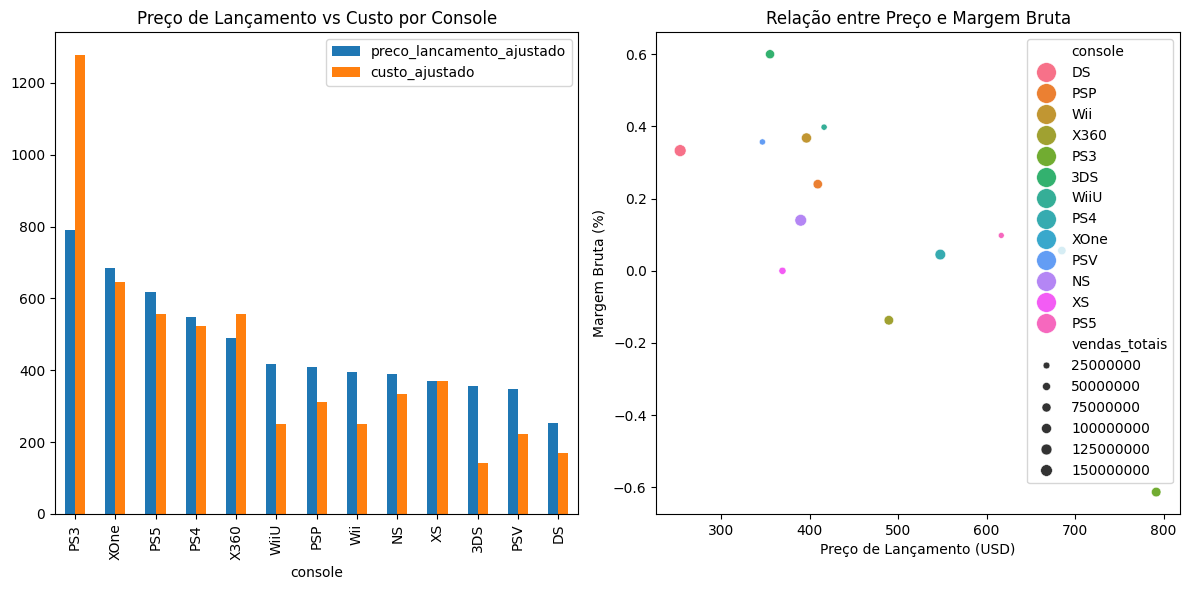

Correlação Margem-Vendas: -0.07, p-value: 0.8148


In [85]:
plt.figure(figsize=(12, 6))

# Gráfico de Barras Comparativas
ax = plt.subplot(1,2,1)
console_metrics.sort_values('preco_lancamento_ajustado', ascending=False).plot(
    x='console', 
    y=['preco_lancamento_ajustado', 'custo_ajustado'], 
    kind='bar', 
    ax=ax,
    title='Preço de Lançamento vs Custo por Console'
)

# Gráfico de Dispersão Margem Bruta
ax = plt.subplot(1,2,2)
sns.scatterplot(
    x='preco_lancamento_ajustado', 
    y='margem_bruta', 
    size='vendas_totais',
    hue='console',
    data=console_metrics,
    s=200,
    ax=ax
)
plt.title('Relação entre Preço e Margem Bruta')
plt.xlabel('Preço de Lançamento (USD)')
plt.ylabel('Margem Bruta (%)')

plt.tight_layout()
plt.show()

# Correlação
margin_corr = console_metrics.groupby('console')[['margem_bruta', 'vendas_totais']].mean().reset_index()
corr, p_value = stats.pearsonr(margin_corr['margem_bruta'], margin_corr['vendas_totais'])
print(f"Correlação Margem-Vendas: {corr:.2f}, p-value: {p_value:.4f}")

#### Relação entre Vendas e Tipo de Console

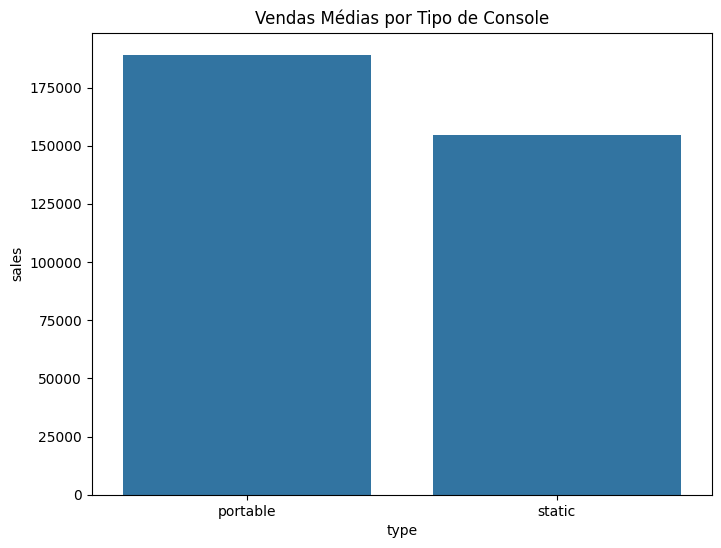

In [80]:
# Calcular vendas médias por tipo
type_sales = merged_df.groupby('type')['sales'].mean().reset_index()

# Gráfico de barras
plt.figure(figsize=(8,6))
sns.barplot(x='type', y='sales', data=type_sales)
plt.title('Vendas Médias por Tipo de Console')
plt.show()

#### Curva de Demanda para Consoles (Usando Preço dos Consoles)
A elasticidade-preço da demanda mede o quanto a quantidade demandada responde a variações do preço. Como veremos a elasticidade é 0,08, desse modo dizemos que a demanda é inelástica no mercado de console de video games.

Elasticidade-Preço da Demanda: 0.080
Intervalo de Confiança 95%: (-1.376, 1.535)
Significância Estatística (p-value): 0.9060


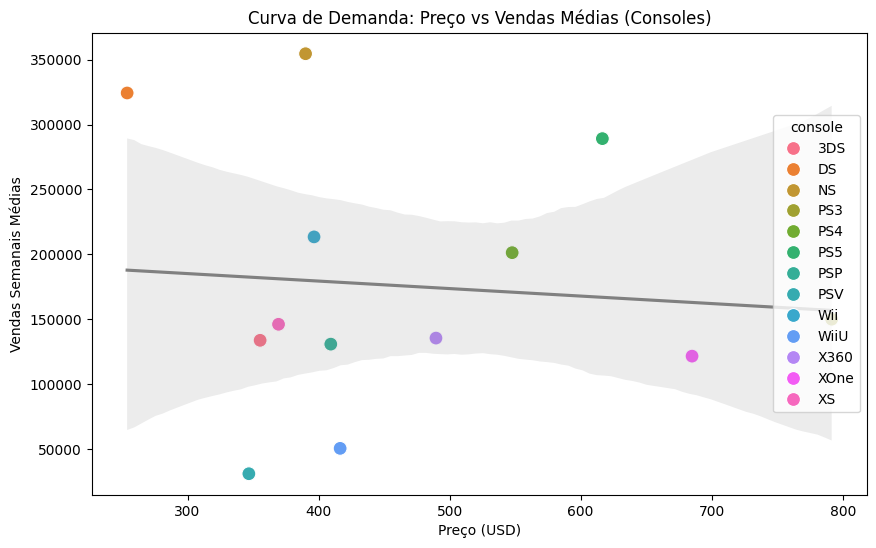

In [92]:
# Criar coluna de preço vigente
merged_df['current_price'] = merged_df['2025 price']

# Agrupar por preço e calcular vendas médias
demand_curve = merged_df.groupby(['console', 'current_price'])['sales'].mean().reset_index()

# Modelagem linear (elasticidade-preço)
import statsmodels.formula.api as smf

model = smf.ols('np.log(sales) ~ np.log(current_price)', data=demand_curve).fit()
elasticidade = model.params['np.log(current_price)']
intervalo_confianca = model.conf_int().loc['np.log(current_price)']
p_value = model.pvalues['np.log(current_price)']

# Resultados
print(f'Elasticidade-Preço da Demanda: {elasticidade:.3f}')
print(f'Intervalo de Confiança 95%: ({intervalo_confianca[0]:.3f}, {intervalo_confianca[1]:.3f})')
print(f'Significância Estatística (p-value): {p_value:.4f}')

# Modelo com interação por tipo
model_tipo = smf.ols('np.log(sales) ~ np.log(current_price) * type', 
                    data=demand_curve.merge(consoles_df, on='console')).fit()

# Gráfico da curva
plt.figure(figsize=(10,6))
sns.scatterplot(x='current_price', y='sales', hue='console', data=demand_curve, s=100)
sns.regplot(x='current_price', y='sales', data=demand_curve, scatter=False, color='grey')
plt.title('Curva de Demanda: Preço vs Vendas Médias (Consoles)')
plt.xlabel('Preço (USD)')
plt.ylabel('Vendas Semanais Médias')
plt.show()

### Estrutura de Mercado

Apesar de nosso dados mostrarem que a Nintendo tem mais do que a metade das vendas do mercado, nós interpretamos que o mercado é mais bem dividido. Nossos dados não tem outros consoles da Sony e Microsoft, como PS2, Xbox Series X e outro que concorreram com os da Nintendo que nós temos.

Nesse sentido, pensamos que o mercado dos consoles é um oligopólio, devido ao fato dessas 3 empresas dominarem o mercado e venderam produtos similares. 

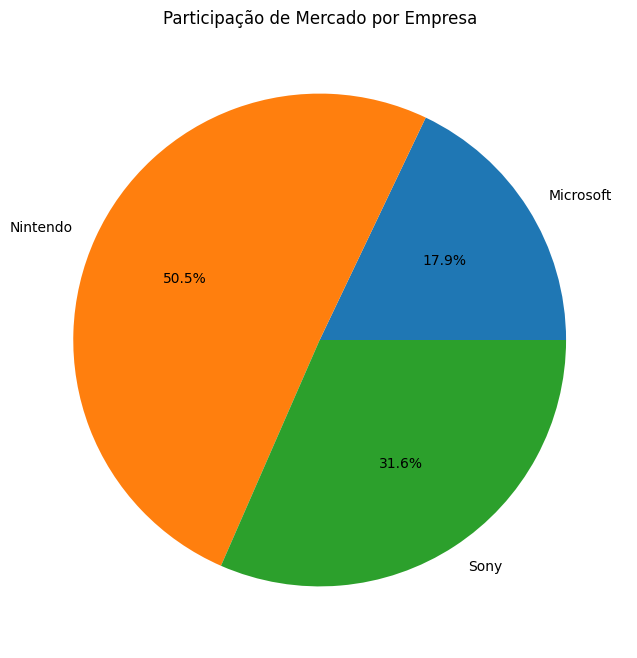

In [82]:
# Calcular vendas totais por empresa
market_share = merged_df.groupby('company')['sales'].sum().reset_index()
market_share['share'] = (market_share['sales'] / market_share['sales'].sum()) * 100

# Gráfico de pizza
plt.figure(figsize=(8,8))
plt.pie(market_share['share'], labels=market_share['company'], autopct='%1.1f%%')
plt.title('Participação de Mercado por Empresa')
plt.show()

#### Índice Herfindahl-Hirschman (HHI)

É uma medida comum de concentração de mercado e é usado para determinar a competitividade do mercado. Um mercado com um HHI abaixo de 1.500 é considerado competitivo, um HHI de 1.500 a 2.500 é moderadamente concentrado e um HHI de 2.500 ou superior é altamente concentrado.

Note abaixo que segundo o índice, esse mercado é altamente concentrado, o que leva uma atenção especial, pois as empresas tem um alto poder de mercado. 

In [83]:
# Calcular HHI
market_share['squared_share'] = (market_share['share']) ** 2
hhi = market_share['squared_share'].sum()
print(f"Índice HHI: {hhi:.2f}")

Índice HHI: 3869.68


## Limitações e Melhorias
- Dados de Preços: A análise de demanda fica limitada pela escassez de variação de preços.

- Fatores Omitidos: A demanda é influenciada por variáveis não disponíveis (e.g., marketing, lançamento de jogos).

- Endogeneidade: O preço pode ser ajustado em resposta às vendas, criando viés.

### Próximos Passos que Pensamos
- Coletar dados históricos mensais de preços dos consoles

- Incluir métricas de jogos (attach rate, títulos lançados)

- Adicionar dados macroeconômicos (PIB, taxa de desemprego)

